So some context first about the data we are going to manipulate.
* The dataset contains FAPAR data (Fraction of Absorbed Photosynthetically Active Radiation)
* The data was computed using raster data taken by a satelite
* Normally, there should be one measurement every 10 days for every zone and landcover.
* Due to external conditions (e.g. clouds), data can be missing.

Our goal is pretty simple: we want to detect if there are any trends for each zone.

We will proceed as follows:
1. Clean missing measurements from the original dataset
1. Group measurements by zone and landcover
1. For every zone:
  1. Do some cleaning for every landcover
  1. Combine the different landcovers data
  1. Remove seasonality by taking yearly averages
  1. Compute the trend
1. Plot the trends on a world map.

We will detail each step along the way.

In [1]:
import pyspark
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime, time

%matplotlib inline

Let's read the parquet file containing all our data, as follows:

In [3]:
from pyspark.conf import SparkConf
conf = SparkConf()
conf.set('spark.yarn.executor.memoryOverhead', 1024)
conf.set('spark.executor.memory', '4g')

In [4]:
sc = pyspark.SparkContext(conf=conf)

In [5]:
sqlCtx = pyspark.SQLContext(sc)

In [6]:
data = sqlCtx.read.parquet("hdfs:/user/eryilmas/stats.parquet")
data

DataFrame[landcover: string, zone: int, date: string, area: bigint, validArea: bigint, BIOPAR_LAI_V1: double, BIOPAR_FAPAR_V1: double, BIOPAR_VPI: double, BIOPAR_NDVI_V2: double, BIOPAR_VCI: double, BIOPAR_TOCR_B0: double]

Next, we want to register this data in a temporary table so we can query it using Spark's SQLContext.

In [7]:
data.registerTempTable("data")

Now although we instructed Spark where the data was and to register it, it did not actually read anything. This is because Spark is lazy: it will postpone doing any task until it the last moment. Requesting data will force it to load it, as follows:

In [8]:
data.take(1)

[Row(landcover=u'Tree_cover_broadleaved_deciduous_open', zone=3246, date=u'2006-03-02', area=2853, validArea=313, BIOPAR_LAI_V1=14.527156549520775, BIOPAR_FAPAR_V1=66.1182108626198, BIOPAR_VPI=None, BIOPAR_NDVI_V2=None, BIOPAR_VCI=None, BIOPAR_TOCR_B0=None)]

Using Spark's SQLContext, we can query our data with SQL-like expressions. Here we are interested in the *zone, landcover, date, FAPAR* and *area* columns.

We will also filter out unwanted rows by specifying that we do not want rows for which we do not have a *FAPAR* value.

In [9]:
data = sqlCtx.sql("SELECT zone, landcover, date date, BIOPAR_FAPAR_V1 fapar, area " + 
                  "FROM data " +
                  "WHERE BIOPAR_FAPAR_V1 is not null").cache()
data.take(1)

[Row(zone=3219, landcover=u'Water_bodies', date=u'2005-11-12', fapar=44.18859162494901, area=11163)]

As you can see, although **null** values have been filtered out, some **FAPAR** values still remain **nan**.
We can filter them out using the **filter** method from Spark. For that, we can either use the **DataFrame**'s method filter, or we can use the **DataFrame** as a regular **RDD**.

The difference is that the **DataFrame** contains **Row**s, for which we can refer to the columns with their names, whereas the **RDD** contains **tuple**s, where we have to select columns based on their index. However, with a regular **RDD**, we can pass any method we want to **filter, map, reduce, ...**, whereas with a **DataFrame**, we have to use pre-defined functions.

In [10]:
def fapar_not_nan(row):
    return row[3] is not None and not np.isnan(row[3])

withoutNaNs = data.rdd.filter(fapar_not_nan).cache()
withoutNaNs.take(1)

[Row(zone=3219, landcover=u'Water_bodies', date=u'2005-12-12', fapar=26.68670891278007, area=11163)]

For grouping, we could use spark's *groupBy* method, or we could first *map* our data to a *(Key, Value)* pair and use the *groupByKey* method. We will use the latter method as we have more fined control over what goes into *Value*.

In [11]:
def by_zone(row):
    return ((row[0]), (row[1], row[2], row[3], row[4]))

by_zone = withoutNaNs.map(by_zone).groupByKey().cache()
by_zone.take(1)

[(0, <pyspark.resultiterable.ResultIterable at 0x6096b90>)]

The result is a list of pairs *(Zone, Values)* where *Values* is a list containing all the values for the specific *Zone* we grouped by.

Spark will combine the different values into a *ResultIterable* object, not really suited for the analysis we will be doing. Instead, we are going to use Pandas and Numpy. So first thing we want to do is to convert our *ResultIterable* into an actual *Pandas* DataFrame.

In [12]:
def iterable_to_pd(row):
    return (row[0], pd.DataFrame(list(row[1]), columns=["landcover", "date", "fapar", "area"]))

by_zone = by_zone.map(iterable_to_pd).cache()
by_zone.take(1)

[(0,                                                landcover        date  \
  0                 Tree_cover_needleleaved_evergreen_open  2003-10-12   
  1       Tree_cover_needleleaved_deciduous_closed_to_open  2011-07-02   
  2                                Consolidated_bare_areas  2008-08-12   
  3              Tree_cover_flooded_fresh_or_brakish_water  2002-09-02   
  4                                             Bare_areas  2015-09-02   
  5                                            Urban_areas  2012-03-23   
  6                 Mosaic_tree_and_shrub_herbaceous_cover  2009-04-02   
  7          Sparse_vegetation_tree_shrub_herbaceous_cover  1999-09-12   
  8                        Tree_cover_flooded_saline_water  2007-07-12   
  9               Tree_cover_needleleaved_deciduous_closed  1999-06-22   
  10                                      Herbaceous_cover  2004-10-12   
  11                                       Mosaic_cropland  1999-07-23   
  12                             Un

Now that we are ready to write our *Combine* task, let's detail the algorithm we are going to write to process each *zone*:

1. Group the dataset by landcover, and for each:
  1. Resample the data monthly (instead of 10-daily) with padding in order to fill some void if there are any
1. Reweight the **FAPAR** values by the area the landcover takes over the **total area**
1. Regroup the dataset by date and take the (monthly) sum
1. Resample the data yearly and remove the 1st and last year of data (to only include full years)

In [13]:
def combine_fapar(zone):
    series = zone[1]
    series["date"] = pd.to_datetime(series["date"])
    series = series.set_index("date")
    
    # Group the dataset by landcover, and for each:
    by_landcover = series.groupby("landcover")
    
    # Resample the data monthly (instead of 10-daily) with padding in order to fill some void if there are any
    by_landcover = by_landcover.resample("1m", how="mean").fillna(method='pad')
    series = by_landcover.reset_index()
    
    # Reweight the FAPAR values by the area the landcover takes over the total area
    total_area = by_landcover["area"].mean().sum()
    series["fapar"] *= series["area"] / total_area
    series = series.drop("area", axis=1)
    
    # Regroup the dataset by date and take the (monthly) sum
    series = series.groupby("date").sum()
    
    # Resample the data yearly and remove the 1st and last year of data (to only include full years)
    yearly_sum = pd.DataFrame(series["fapar"].resample("12m", "mean")[1:-1])
    
    return (zone[0], series, yearly_sum)

combined = by_zone.map(combine_fapar).cache()
combined.take(1)

[(0,                   fapar
  date                   
  1998-12-31   705.383215
  1999-01-31  1026.880271
  1999-02-28  1081.945148
  1999-03-31  1332.351289
  1999-04-30  1269.120202
  1999-05-31  1366.718362
  1999-06-30  1370.308991
  1999-07-31  1448.372657
  1999-08-31  1479.764050
  1999-09-30  1455.435323
  1999-10-31  1416.062352
  1999-11-30  1338.989129
  1999-12-31  1134.838352
  2000-01-31  1091.194419
  2000-02-29  1118.628034
  2000-03-31  1281.332751
  2000-04-30  1393.246562
  2000-05-31  1447.431760
  2000-06-30  1363.774169
  2000-07-31  1459.584208
  2000-08-31  1501.529952
  2000-09-30  1413.123156
  2000-10-31  1425.937546
  2000-11-30  1284.958342
  2000-12-31  1097.853749
  2001-01-31  1059.785935
  2001-02-28  1106.460368
  2001-03-31  1181.529809
  2001-04-30  1365.957279
  2001-05-31     7.224863
  ...                 ...
  2013-05-31  1539.630848
  2013-06-30  1523.899262
  2013-07-31  1525.911448
  2013-08-31  1563.763275
  2013-09-30  1528.148954
  2013-10

Finally, we can compute the trend using a linear regression (OLS).

In [14]:
def min_years(datas):
    return len(datas[2]) >=5 

def ols(datas):    
    yearly_series = datas[2]
    x, y = yearly_series.index.astype(int) // (10**9 * 60 * 24 * 30), yearly_series["fapar"]
    X = np.c_[np.ones(len(x)), x]
    return (datas[0], datas[1], datas[2], np.linalg.pinv(X).dot(y))

trends = combined.filter(min_years).map(ols).cache()

Next we will plot the trends.
We are interested in the highest and lowest trends in our data.

Let's define our plotting function and plot the trends by descending order.

In [15]:
zonecodes = pd.read_csv("./zonecodes.csv")
def plotTopTrends(trendsCollected):
    for zone, series, yearly_series, trend in trendsCollected:
        if not np.isnan(trend[0]) and not np.isnan(trend[1]):
            codes = zonecodes[zonecodes['ADM1_CODE'] == zone][["ADM0_NAME", "ADM1_NAME"]]
            codes["Trend"] = trend[1]
            print codes
                
            pdf = series.copy()
            pdf["ols"] = pdf.index.astype(int) / (10**9 * 60 * 24 * 30) * trend[1] + trend[0]
            pdf[["fapar", "ols"]].plot(figsize=(16,4))

            #sns.regplot(x="unix_date", y="fapar", data=series, scatter=False)
            plt.show()

         ADM0_NAME     ADM1_NAME     Trend
3396  Saint Helena  Saint Helena  0.085356


/opt/rh/python27/root/usr/lib64/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


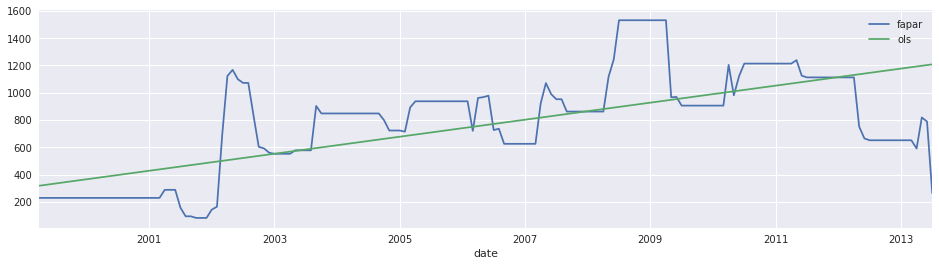

     ADM0_NAME ADM1_NAME     Trend
2770   Vanuatu     Tafea  0.071657


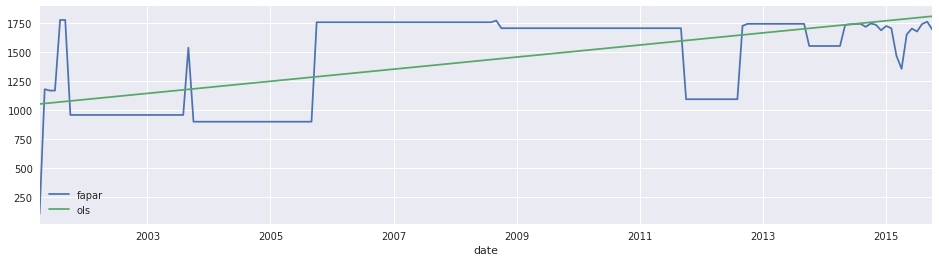

     ADM0_NAME  ADM1_NAME     Trend
2558    Turkey  Canakkale  0.060181


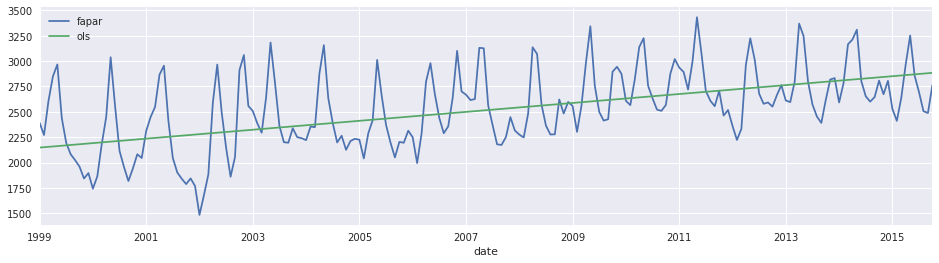

     ADM0_NAME ADM1_NAME     Trend
2561    Turkey   Denizli  0.058052


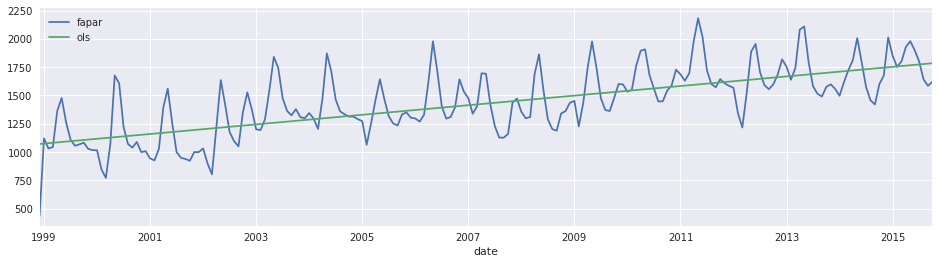

   ADM0_NAME ADM1_NAME     Trend
59   Albania    Permet  0.056481


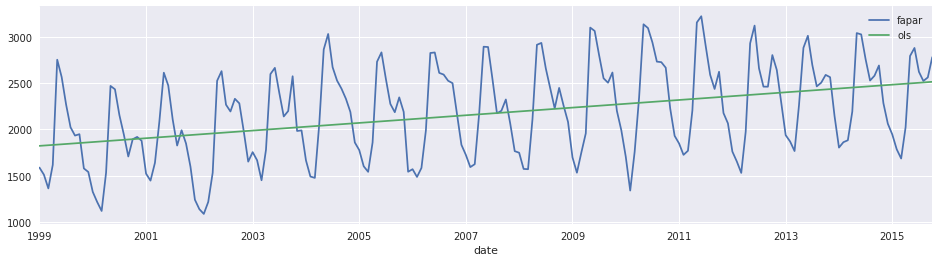

    ADM0_NAME      ADM1_NAME     Trend
976    Greece  Sterea Ellada  0.056105


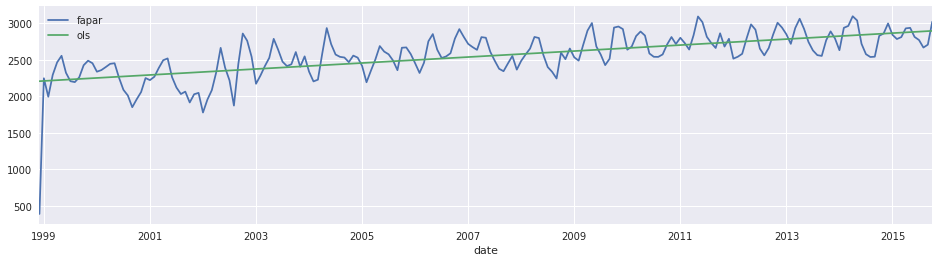

   ADM0_NAME ADM1_NAME     Trend
80   Algeria    Bouira  0.055502


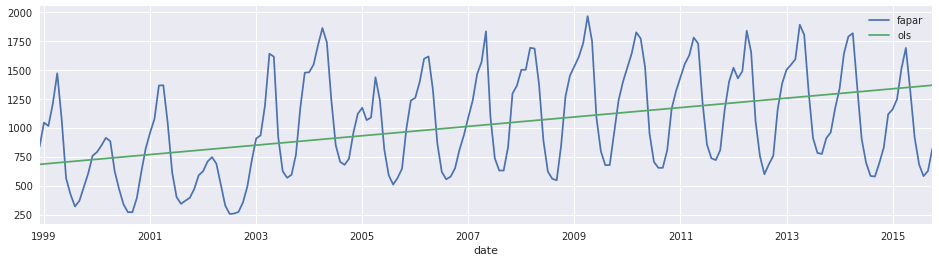

    ADM0_NAME           ADM1_NAME     Trend
973    Greece  Kentriki Makedonia  0.055223


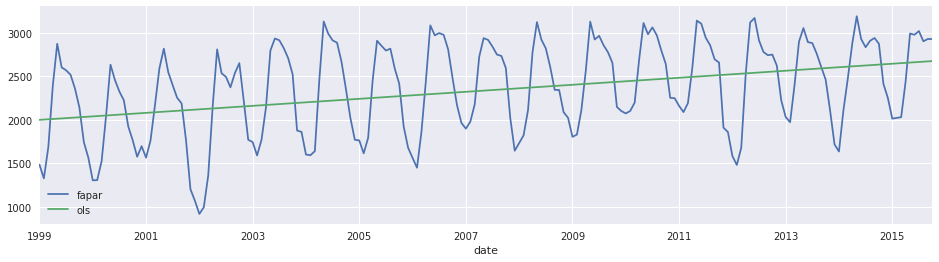

     ADM0_NAME ADM1_NAME     Trend
2592    Turkey    Manisa  0.054797


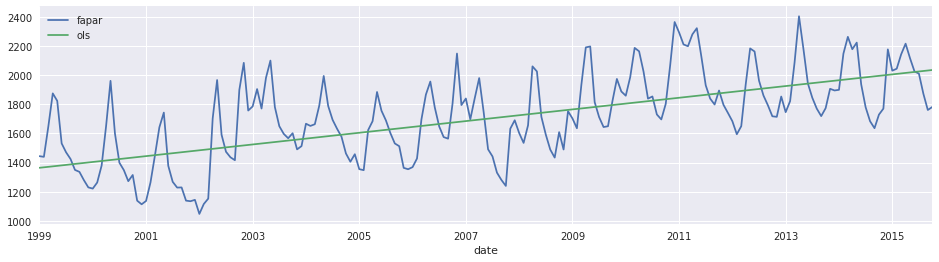

     ADM0_NAME ADM1_NAME    Trend
2590    Turkey   Kutahya  0.05472


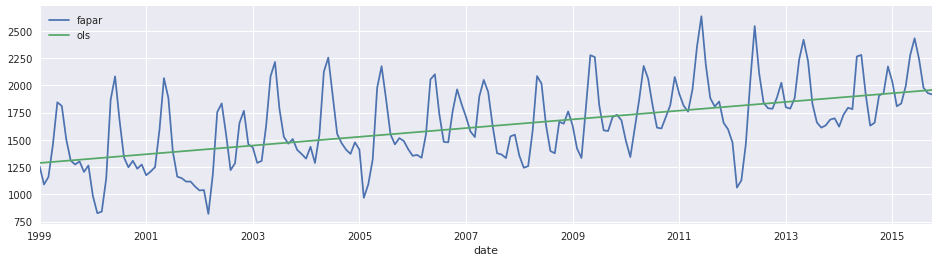

In [16]:
plotTopTrends(trends.sortBy(lambda x: x[3][1], ascending=False).take(10))

    ADM0_NAME     ADM1_NAME     Trend
983   Grenada  St. Andrew's -0.041493


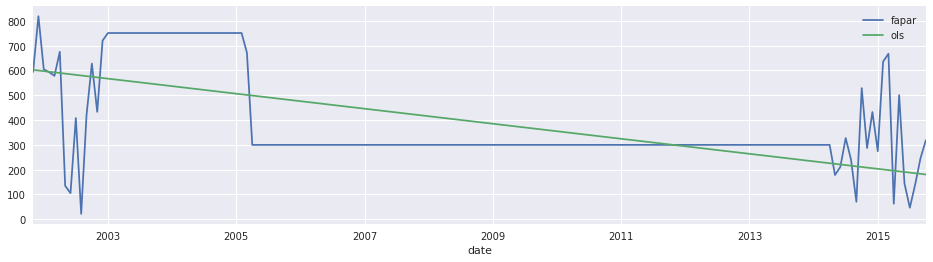

    ADM0_NAME ADM1_NAME     Trend
458  Cambodia    Pailin -0.032666


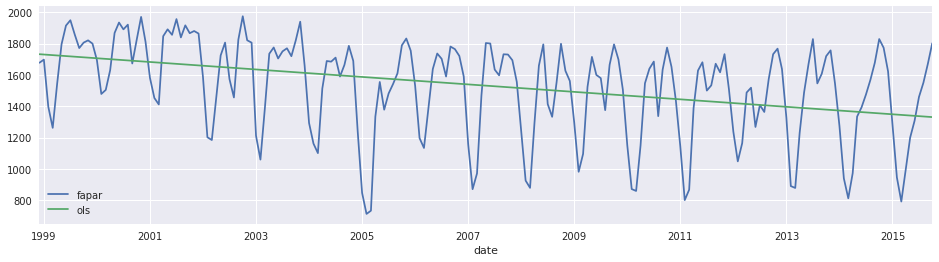

        ADM0_NAME        ADM1_NAME     Trend
2149  Saint Lucia  Region Number 1 -0.025877


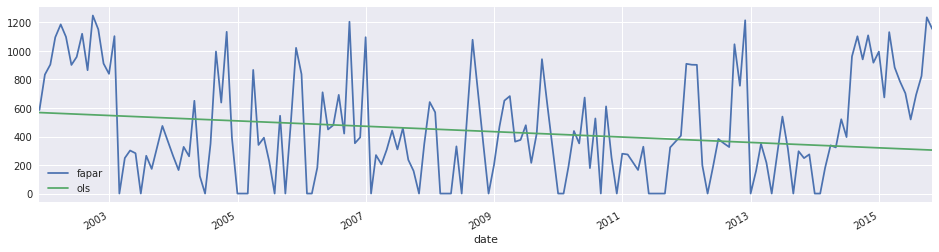

        ADM0_NAME ADM1_NAME     Trend
1729  New Zealand  Auckland -0.024999


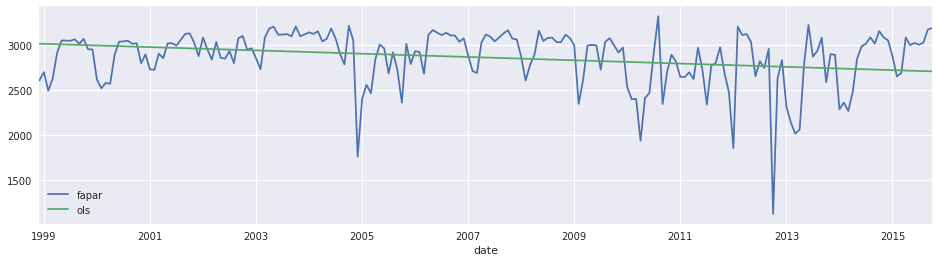

     ADM0_NAME ADM1_NAME     Trend
3102    Guinea   Conakry -0.019708


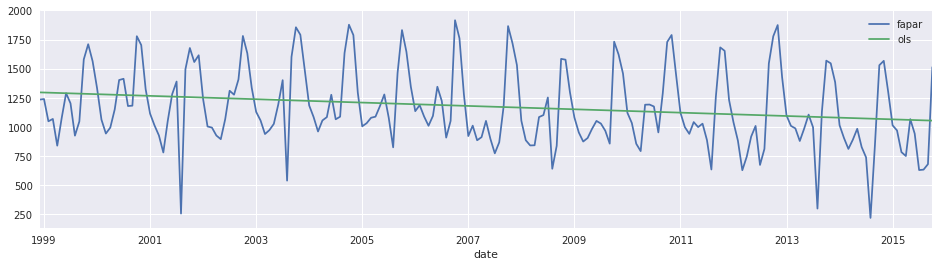

    ADM0_NAME   ADM1_NAME     Trend
445  Cambodia  Battambang -0.015549


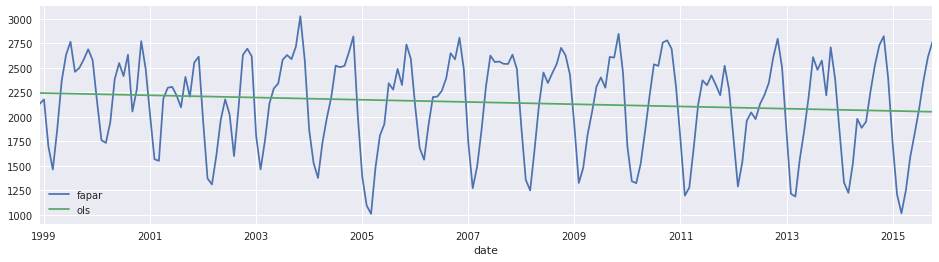

    ADM0_NAME ADM1_NAME     Trend
454  Cambodia    Kratie -0.013667


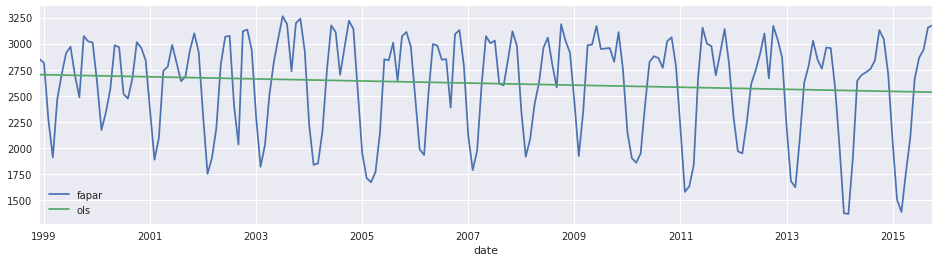

       ADM0_NAME       ADM1_NAME    Trend
3313  Martinique  Fort-de-France -0.01198


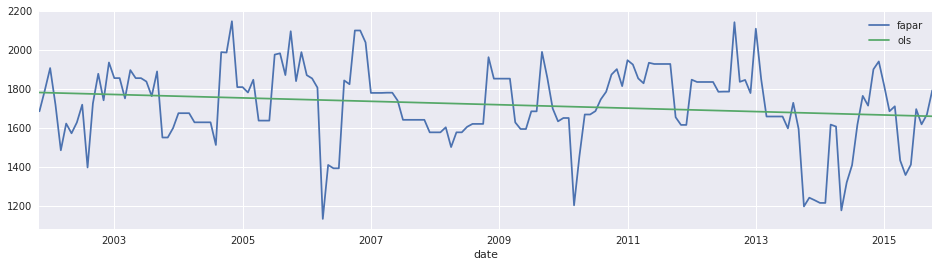

     ADM0_NAME   ADM1_NAME     Trend
2297  Suriname  Paramaribo -0.011352


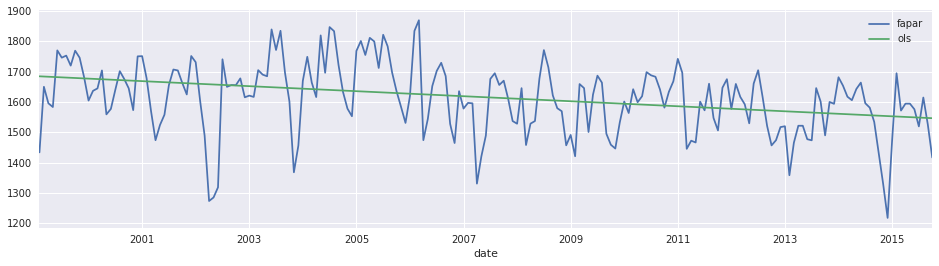

                        ADM0_NAME    ADM1_NAME     Trend
3210  United Republic of Tanzania  Pemba North -0.010577


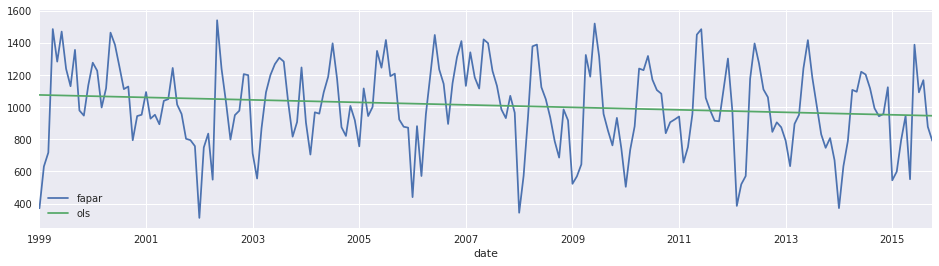

In [17]:
plotTopTrends(trends.sortBy(lambda x: x[3][1], ascending=True).take(10))

Now we can create a world map and color each zone by its trend.
First, let's only take each region and its corresponding trend.

In [18]:
def mean_trends(zone):
    return (zone[0], zone[3][1])

trend_by_zone = dict(trends.map(mean_trends).filter(lambda x: not np.isnan(x[1])).collect())

We will also draw a colormap but by default *matplotlib* will center the colormap based on the mean of the values.
We would like to center the colormap on 0.0, so as to fill zones with no trend (0) in yellow, zones with an upwards trend in green and zones with a downwards trend in red.

We define a function to shift the colormap and center it around the point we want.

In [19]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

Now we can actually draw the map.

In [20]:
def plot_map(zones_trend, lllon=-180, lllat=-90, urlon=180, urlat=90): 
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)

    map = Basemap(llcrnrlon=lllon, llcrnrlat=lllat, 
                  urcrnrlon=urlon, urcrnrlat=urlat, 
                  resolution='c', 
                  projection='cyl')

    #map.drawmapboundary(fill_color='aqua')
    #map.fillcontinents(color='#ddaa66', lake_color='aqua')
    #map.drawcoastlines()

    map.readshapefile('./GAUL2013/GAUL1', 'GAUL1')

    patches = []
    colors = []
    for info, shape in zip(map.GAUL1_info, map.GAUL1):
        zone_trend = zones_trend.get(info['ADM1_CODE'])
        if zone_trend is not None:
            patches.append( Polygon(np.array(shape), True ))
            colors.append(zone_trend)

    vmax = np.percentile(colors, 95)
    vmin = np.percentile(colors, 5)
    midpoint = 1 - vmax/(vmax + abs(vmin))
    colormap = shiftedColorMap(plt.get_cmap('RdYlGn'), midpoint=midpoint, name='shifted')

    pc = PatchCollection(patches, cmap=colormap, linewidths=1., zorder=2)
    pc.set_array(np.array(colors))
    pc.set_clim([vmin, vmax])
    ax.add_collection(pc)
    plt.colorbar(pc)

    plt.show()


This is what it looks like worldwide.

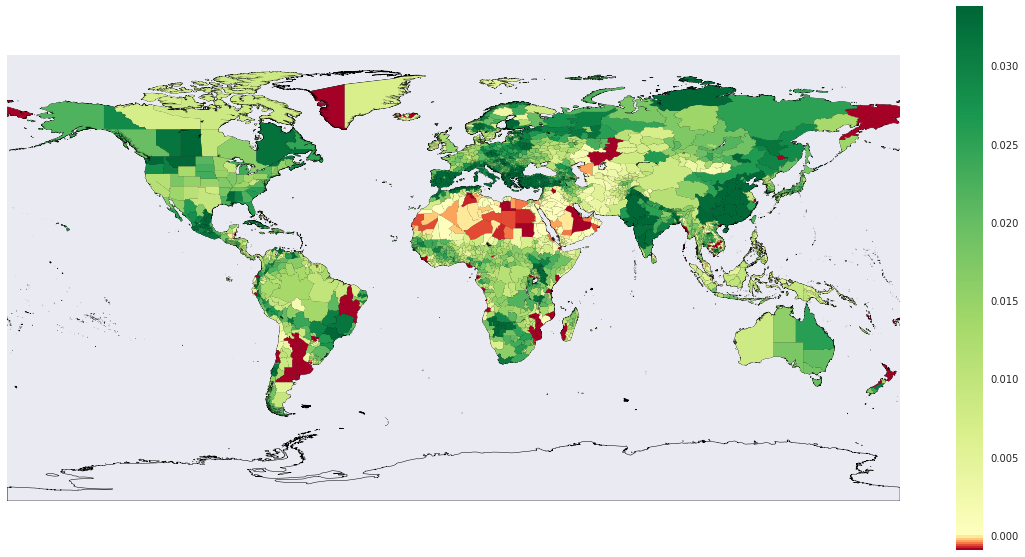

In [21]:
plot_map(trend_by_zone)

Europe:

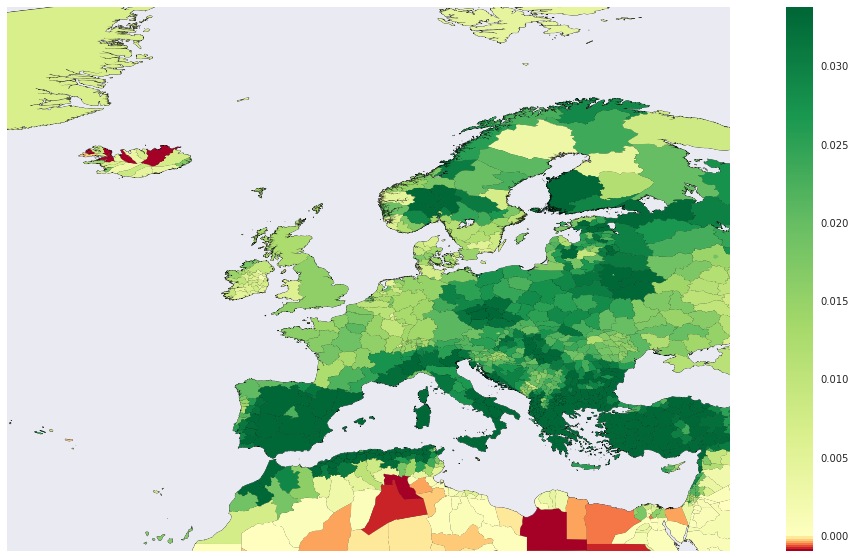

In [22]:
plot_map(trend_by_zone, lllon=-31.5, lllat=27, urlon=39, urlat=80)

Africa:

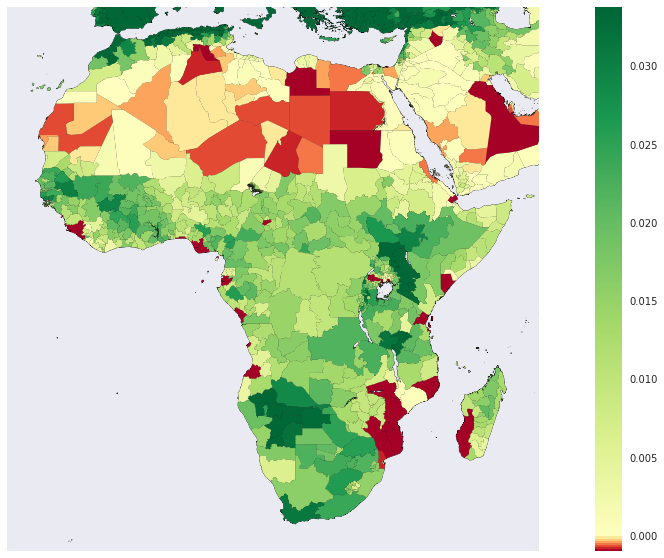

In [23]:
plot_map(trend_by_zone, lllon=-21.6, lllat=-38.7, urlon=55.2, urlat=39.8)